# Gene expression re-normalization

We need to renormalize gene expression to reduce chrM bias or MYC gene expression amplification bias.

# Outline
- [Introduction](#gene-expression-re-normalization)
- [Setup](#setup)
- [Data](#data)
- [Reproduce problem](#reproduce-chrm-bias)

# Setup

In [2]:
%load_ext autoreload
%autoreload 2
from taigapy import TaigaClient
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from cds import plotting
from mgenepy.utils import helper
#from depmap_omics_upload import tracker as track

tc = TaigaClient()

# Data

In [7]:
%%capture

OmicsExpressionProteinCodingGenesTPMLogp1 = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsExpressionProteinCodingGenesTPMLogp1')

In [8]:
OmicsExpressionProteinCodingGenesTPMLogp1.shape

(1882, 19193)

In [9]:
%%capture

OmicsExpressionAllGenesEffectiveLengthProfile = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsExpressionAllGenesEffectiveLengthProfile')
OmicsExpressionAllGenesTPMLogp1Profile = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsExpressionAllGenesTPMLogp1Profile')
OmicsExpressionGenesExpectedCountProfile = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsExpressionGenesExpectedCountProfile')
OmicsDefaultModelProfiles = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsDefaultModelProfiles')
OmicsDefaultModelConditionProfiles = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsDefaultModelConditionProfiles')


In [10]:
profile_to_model_dict = OmicsDefaultModelProfiles.query("ProfileType == 'rna'").\
        set_index("ProfileID").\
        drop("ProfileType", axis=1).\
        to_dict()["ModelID"]

In [11]:
OmicsExpressionProteinCodingGenesTPMLogp1.shape, \
    OmicsExpressionAllGenesEffectiveLengthProfile.shape, \
    OmicsExpressionAllGenesTPMLogp1Profile.shape, \
    OmicsExpressionGenesExpectedCountProfile.shape, \
    OmicsExpressionProteinCodingGenesTPMLogp1.shape

((1882, 19193), (1904, 60605), (1904, 53961), (1904, 54353), (1882, 19193))

In [12]:
OmicsExpressionAllGenesEffectiveLengthProfile_matched_genes = OmicsExpressionAllGenesEffectiveLengthProfile.loc[:, OmicsExpressionGenesExpectedCountProfile.columns]

In [13]:
OmicsExpressionAllGenesEffectiveLengthProfile_matched_genes.shape, OmicsExpressionGenesExpectedCountProfile.shape

((1904, 54353), (1904, 54353))

# Reproduce TPM for protein coding genes

In [14]:
def calculate_tpm(counts_df, transcripts_length_df):
    """https://github.com/deweylab/RSEM/blob/8bc1e2115493c0cdf3c6bee80ef7a21a91b2acce/WriteResults.h#L77"""
    assert counts_df.shape == transcripts_length_df.shape

    denom = counts_df.sum(axis=1)
    denom = denom.where(denom > 1e-300, 1)
    print(denom.isnull().sum().sum())
    frac = counts_df.div(denom, axis=0)
    print(frac.isnull().sum().sum())

    transcripts_length_df = transcripts_length_df.where(transcripts_length_df > 1e-300, 1)
    fpkm = frac * 1e9 / transcripts_length_df
    print(fpkm.isnull().sum().sum())

    fpkm_sum = fpkm.sum(axis=1)
    fpkm_denom = fpkm_sum.where(fpkm_sum > 1e-300, 1)
    print(fpkm_denom.isnull().sum().sum())

    tpm_df = (fpkm.div(fpkm_denom, axis=0)) * 1e6
    print(tpm_df.isnull().sum().sum())
    return np.log2(tpm_df+1)

In [15]:
OmicsExpressionGenesExpectedCountProfile_tpm = calculate_tpm(OmicsExpressionGenesExpectedCountProfile, OmicsExpressionAllGenesEffectiveLengthProfile_matched_genes)

0
0
0
0
0


In [16]:
mybiomart = helper.generateGeneNames(ensemble_server="http://nov2020.archive.ensembl.org/biomart", useCache=False)

downloading gene names from biomart


In [17]:
protcod_rename = {}
for _, i in mybiomart[
    (~mybiomart.entrezgene_id.isna()) & (mybiomart.gene_biotype == "protein_coding")
].iterrows():
    if i.ensembl_gene_id not in protcod_rename:
        protcod_rename.update(
            {
                i.hgnc_symbol + " (" + i.ensembl_gene_id + ")": i.hgnc_symbol
                + " ("
                + str(int(i.entrezgene_id))
                + ")"
            }
        )

In [18]:
protcod_rename

{'MT-ND1 (ENSG00000198888)': 'MT-ND1 (4535)',
 'MT-ND2 (ENSG00000198763)': 'MT-ND2 (4536)',
 'MT-CO1 (ENSG00000198804)': 'MT-CO1 (4512)',
 'MT-CO2 (ENSG00000198712)': 'MT-CO2 (4513)',
 'MT-ATP8 (ENSG00000228253)': 'MT-ATP8 (4509)',
 'MT-ATP6 (ENSG00000198899)': 'MT-ATP6 (4508)',
 'MT-CO3 (ENSG00000198938)': 'MT-CO3 (4514)',
 'MT-ND3 (ENSG00000198840)': 'MT-ND3 (4537)',
 'MT-ND4L (ENSG00000212907)': 'MT-ND4L (4539)',
 'MT-ND4 (ENSG00000198886)': 'MT-ND4 (4538)',
 'MT-ND5 (ENSG00000198786)': 'MT-ND5 (4540)',
 'MT-ND6 (ENSG00000198695)': 'MT-ND6 (4541)',
 'MT-CYB (ENSG00000198727)': 'MT-CYB (4519)',
 'AC240274.1 (ENSG00000271254)': 'AC240274.1 (102724250)',
 'OPRL1 (ENSG00000277044)': 'OPRL1 (4987)',
 'NPBWR2 (ENSG00000277339)': 'NPBWR2 (2832)',
 'MYT1 (ENSG00000276876)': 'MYT1 (4661)',
 'PCMTD2 (ENSG00000280663)': 'PCMTD2 (55251)',
 'KIR3DL3 (ENSG00000275433)': 'KIR3DL3 (115653)',
 'KIR2DL3 (ENSG00000273947)': 'KIR2DL3 (3804)',
 'KIR2DL1 (ENSG00000273510)': 'KIR2DL1 (3802)',
 'KIR2DL4 (E

In [19]:
OmicsExpressionGenesExpectedCountProfile_tpm.columns = OmicsExpressionGenesExpectedCountProfile_tpm.columns.map(protcod_rename)
OmicsExpressionGenesExpectedCountProfile_tpm = OmicsExpressionGenesExpectedCountProfile_tpm.loc[:, ~OmicsExpressionGenesExpectedCountProfile_tpm.columns.isnull()]

In [20]:
OmicsExpressionAllGenesTPMLogp1Profile.columns = OmicsExpressionAllGenesTPMLogp1Profile.columns.map(protcod_rename)
OmicsExpressionAllGenesTPMLogp1Profile = OmicsExpressionAllGenesTPMLogp1Profile.loc[:, ~OmicsExpressionAllGenesTPMLogp1Profile.columns.isnull()]

In [21]:
from scipy.stats import pearsonr

tpm_correlation_list = []
for gene in OmicsExpressionAllGenesTPMLogp1Profile.columns:
    tpm_correlation_list.append(pearsonr(OmicsExpressionGenesExpectedCountProfile_tpm.loc[:, gene], OmicsExpressionAllGenesTPMLogp1Profile.loc[:, gene])[0])

In [22]:
np.isnan(tpm_correlation_list).sum(), np.min(tpm_correlation_list), np.mean(tpm_correlation_list)

(0, 0.856137599505253, 0.9998655014281763)

<Axes: ylabel='Density'>

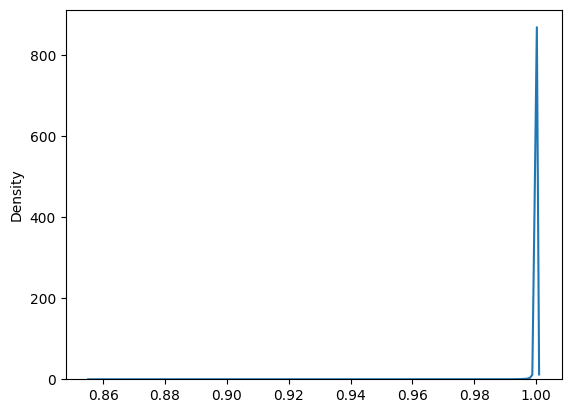

In [23]:
sns.kdeplot(tpm_correlation_list)

In [24]:
OmicsExpressionGenesExpectedCountProfile_tpm.isnull().sum().sum()

0

In [25]:
OmicsExpressionGenesExpectedCountProfile_tpm.loc[:, "Model"] = OmicsExpressionGenesExpectedCountProfile_tpm.index.map(profile_to_model_dict)
OmicsExpressionGenesExpectedCountModel_tpm = OmicsExpressionGenesExpectedCountProfile_tpm.set_index("Model")
OmicsExpressionGenesExpectedCountModel_tpm = OmicsExpressionGenesExpectedCountModel_tpm.loc[OmicsExpressionProteinCodingGenesTPMLogp1.index, :]

In [26]:
OmicsExpressionGenesExpectedCountProfile_tpm.shape

(1904, 19194)

# Reproduce chrM bias

In [27]:
sample_median_expression = OmicsExpressionProteinCodingGenesTPMLogp1.median(axis=1)
sample_median_expression_rank = sample_median_expression.rank()

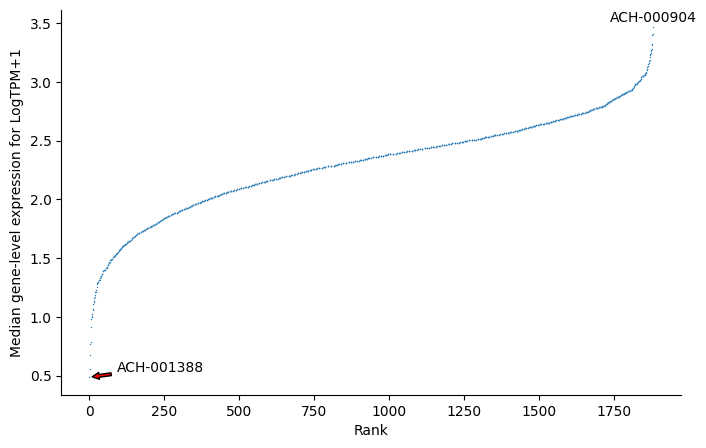

In [28]:
top_1_sample_index = sample_median_expression.argmax()
top_1_sample_rank = sample_median_expression_rank[top_1_sample_index]
top_1_sample = sample_median_expression.index[top_1_sample_index]
top_1_sample_expression = sample_median_expression[top_1_sample_index]
bottom_1_sample_index = sample_median_expression.argmin()
bottom_1_sample_rank = sample_median_expression_rank[bottom_1_sample_index]
bottom_1_sample = sample_median_expression.index[bottom_1_sample_index]
bottom_1_sample_expression = sample_median_expression[bottom_1_sample_index]

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
sns.scatterplot(y=sample_median_expression, x=sample_median_expression_rank, ax=ax, s=1)
ax.set_xlabel("Rank")
ax.set_ylabel("Median gene-level expression for LogTPM+1")
ax.annotate(top_1_sample, xy=(top_1_sample_rank, top_1_sample_expression), xytext=(0, 2), ha='center', textcoords='offset points', va='bottom')
ax.annotate(bottom_1_sample, xy=(bottom_1_sample_rank, bottom_1_sample_expression), 
            xytext=(bottom_1_sample_rank+50, 2), ha='center', va='bottom', textcoords='offset points', 
                arrowprops = dict(arrowstyle="simple", facecolor='red'))

sns.despine()

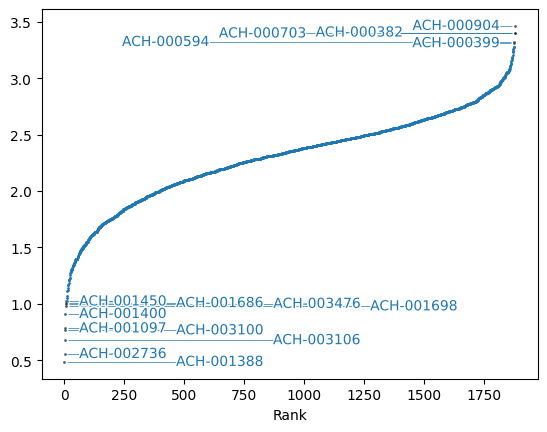

In [29]:
plotting.waterfall_plot(sample_median_expression, s=1)

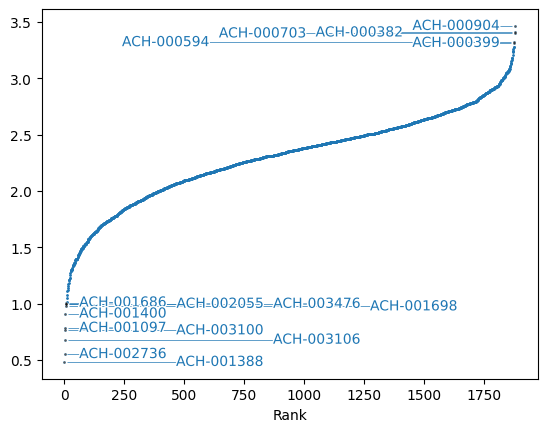

In [30]:
new_sample_median_expression = OmicsExpressionGenesExpectedCountModel_tpm.median(axis=1)
plotting.waterfall_plot(new_sample_median_expression, s=1)

In [31]:
new_sample_median_expression.head()

ACH-001113    2.577495
ACH-001289    2.433611
ACH-001339    2.251976
ACH-001979    1.856811
ACH-002438    2.345780
dtype: float64

/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/cds/plotting/__init__.py:537: UserWarning: adjustText not found. Install to have labels moved off points.
  warn("adjustText not found. Install to have labels moved off points.")


(0.0, 18.0)

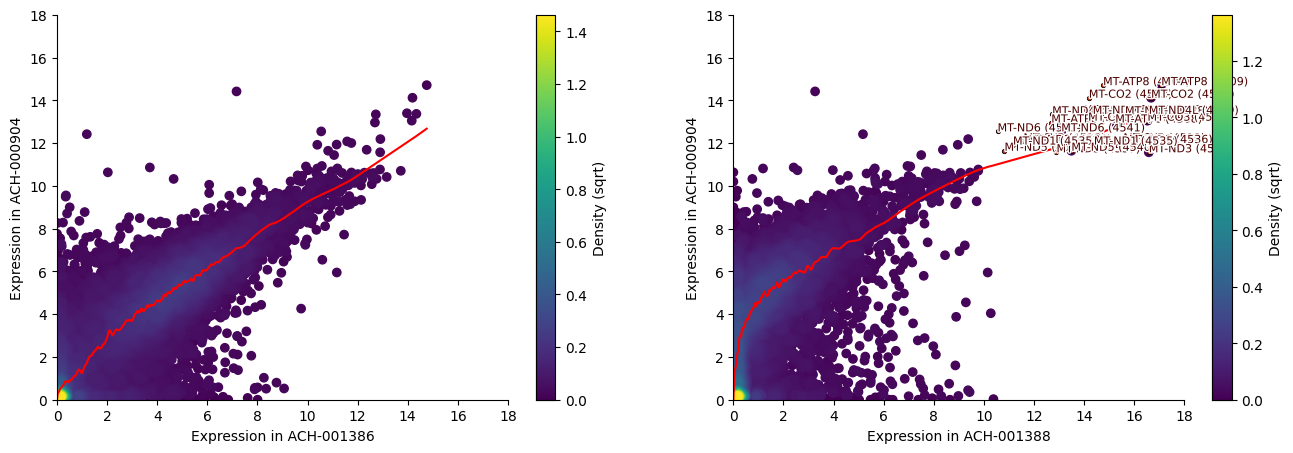

In [32]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(16, 5)
chrM_labels = OmicsExpressionProteinCodingGenesTPMLogp1.columns[OmicsExpressionProteinCodingGenesTPMLogp1.columns.str.contains("^MT-")]
highest_sample = OmicsExpressionProteinCodingGenesTPMLogp1.loc['ACH-001386', :]
lowest_sample = OmicsExpressionProteinCodingGenesTPMLogp1.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax[0],
                         label_specific=chrM_labels)
sns.despine()
                         
ax[0].set_xlabel("Expression in ACH-001386")
ax[0].set_ylabel("Expression in ACH-000904")
ax[0].set_xlim(0, 18)
ax[0].set_ylim(0, 18)

highest_sample = OmicsExpressionProteinCodingGenesTPMLogp1.loc['ACH-001388', :]
lowest_sample = OmicsExpressionProteinCodingGenesTPMLogp1.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax[1],
                         label_specific=chrM_labels)
sns.despine()
                         
ax[1].set_xlabel("Expression in ACH-001388")
ax[1].set_ylabel("Expression in ACH-000904")
ax[1].set_xlim(0, 18)
ax[1].set_ylim(0, 18)

(0.0, 18.0)

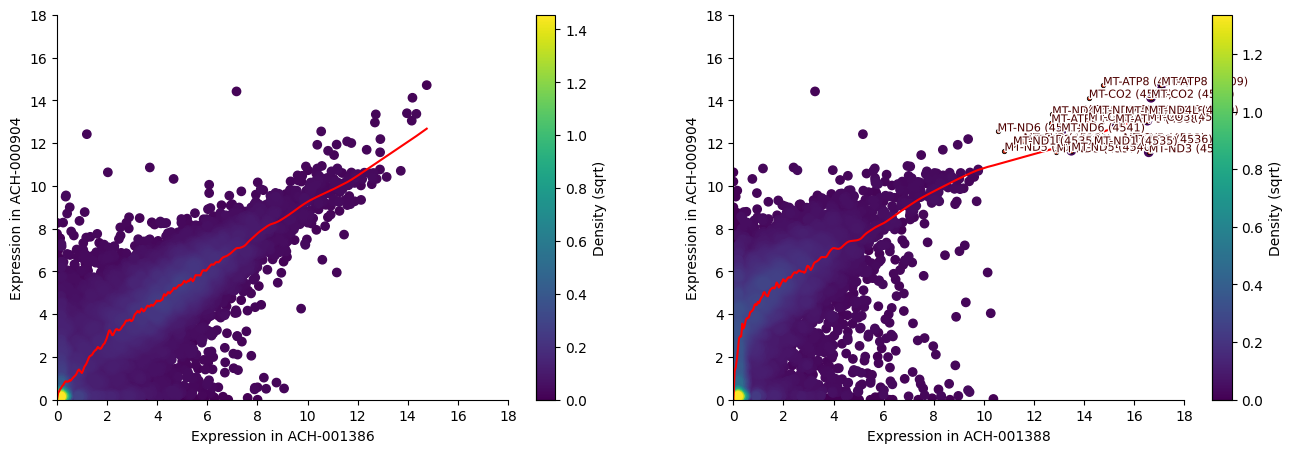

In [33]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(16, 5)
chrM_labels = OmicsExpressionGenesExpectedCountModel_tpm.columns[OmicsExpressionGenesExpectedCountModel_tpm.columns.str.contains("^MT-")]
highest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-001386', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax[0],
                         label_specific=chrM_labels)
sns.despine()
                         
ax[0].set_xlabel("Expression in ACH-001386")
ax[0].set_ylabel("Expression in ACH-000904")
ax[0].set_xlim(0, 18)
ax[0].set_ylim(0, 18)

highest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-001388', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax[1],
                         label_specific=chrM_labels)
sns.despine()
                         
ax[1].set_xlabel("Expression in ACH-001388")
ax[1].set_ylabel("Expression in ACH-000904")
ax[1].set_xlim(0, 18)
ax[1].set_ylim(0, 18)

Text(0.5, 0, 'All gene median expression')

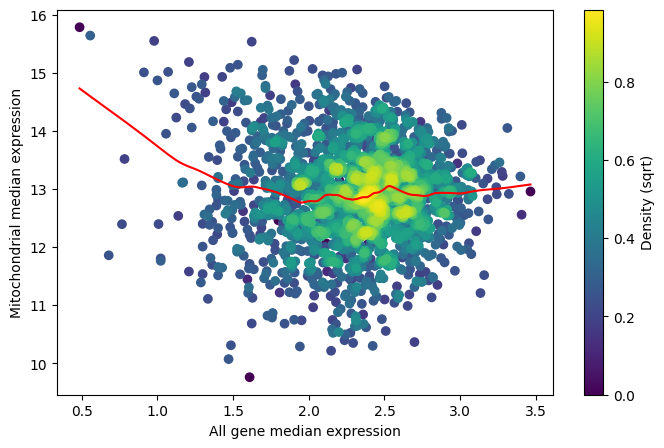

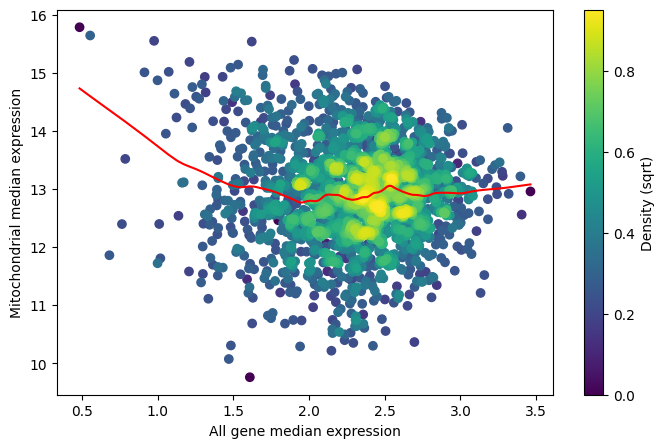

In [34]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
plotting.density_scatter(OmicsExpressionProteinCodingGenesTPMLogp1.loc[:, :].median(axis=1),
                         OmicsExpressionProteinCodingGenesTPMLogp1.loc[:, chrM_labels].median(axis=1),
                         ax=ax)
ax.set_ylabel("Mitochondrial median expression")
ax.set_xlabel("All gene median expression")

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
plotting.density_scatter(OmicsExpressionGenesExpectedCountModel_tpm.loc[:, :].median(axis=1),
                         OmicsExpressionGenesExpectedCountModel_tpm.loc[:, chrM_labels].median(axis=1),
                         ax=ax)
ax.set_ylabel("Mitochondrial median expression")
ax.set_xlabel("All gene median expression")

# Apply the correction

In [35]:
def calculate_tpm_correct_chrM_log(counts_df, transcripts_length_df):
    """https://github.com/deweylab/RSEM/blob/8bc1e2115493c0cdf3c6bee80ef7a21a91b2acce/WriteResults.h#L77"""
    assert counts_df.shape == transcripts_length_df.shape
    EPSILON = 1e-300

    chrM_labels = counts_df.columns.str.contains("^MT-")
    print(chrM_labels.sum())

    denom = counts_df.loc[:, ~chrM_labels].sum(axis=1)
    denom = denom.where(denom > EPSILON, 1)
    print(denom.isnull().sum().sum())
    frac = counts_df.div(denom, axis=0)
    print(frac.isnull().sum().sum())

    transcripts_length_df = transcripts_length_df.where(transcripts_length_df > EPSILON, 1)
    fpkm = frac * 1e9 / transcripts_length_df
    print(fpkm.isnull().sum().sum())

    fpkm_sum = fpkm.loc[:, ~chrM_labels].sum(axis=1)
    fpkm_denom = fpkm_sum.where(fpkm_sum > EPSILON, 1)
    print(fpkm_denom.isnull().sum().sum())

    tpm_df = (fpkm.div(fpkm_denom, axis=0)) * 1e6
    print(tpm_df.isnull().sum().sum())
    return np.log2(tpm_df+1)

In [36]:
OmicsExpressionGenesExpectedCountProfile_tpm_chrM = calculate_tpm_correct_chrM_log(OmicsExpressionGenesExpectedCountProfile, 
                                                                               OmicsExpressionAllGenesEffectiveLengthProfile_matched_genes)
OmicsExpressionGenesExpectedCountProfile_tpm_chrM.columns = OmicsExpressionGenesExpectedCountProfile_tpm_chrM.columns.map(protcod_rename)
OmicsExpressionGenesExpectedCountProfile_tpm_chrM = OmicsExpressionGenesExpectedCountProfile_tpm_chrM.loc[:, ~OmicsExpressionGenesExpectedCountProfile_tpm_chrM.columns.isnull()]

OmicsExpressionGenesExpectedCountProfile_tpm_chrM.loc[:, "Model"] = OmicsExpressionGenesExpectedCountProfile_tpm_chrM.index.map(profile_to_model_dict)
OmicsExpressionGenesExpectedCountModel_tpm_chrM = OmicsExpressionGenesExpectedCountProfile_tpm_chrM.set_index("Model")
OmicsExpressionGenesExpectedCountModel_tpm_chrM = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc[OmicsExpressionProteinCodingGenesTPMLogp1.index, :]

15
0
0
0
0
0


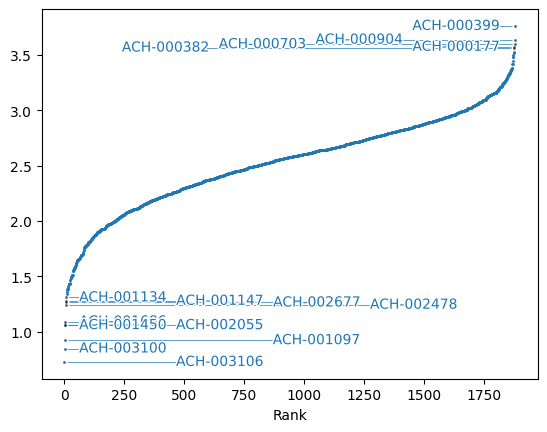

In [37]:
new_sample_median_expression = OmicsExpressionGenesExpectedCountModel_tpm_chrM.median(axis=1)
plotting.waterfall_plot(new_sample_median_expression, s=1)

Text(0.5, 0, 'All gene median expression')

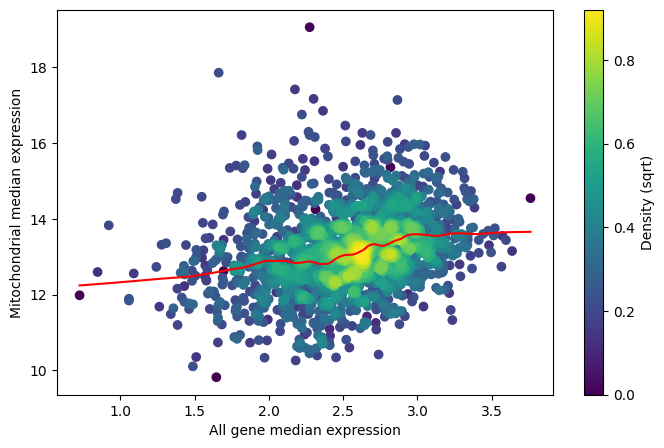

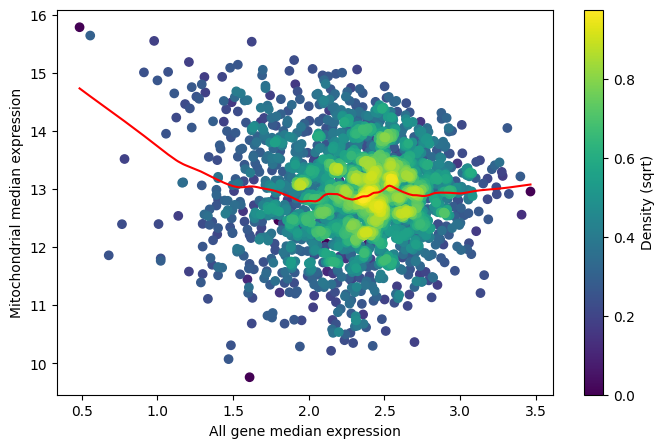

In [38]:
chrM_labels = OmicsExpressionGenesExpectedCountModel_tpm.columns[OmicsExpressionGenesExpectedCountModel_tpm.columns.str.contains("^MT-")]

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
plotting.density_scatter(OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc[:, :].median(axis=1),
                         OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc[:, chrM_labels].median(axis=1),
                         ax=ax)
ax.set_ylabel("Mitochondrial median expression")
ax.set_xlabel("All gene median expression")

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
plotting.density_scatter(OmicsExpressionAllGenesTPMLogp1Profile.loc[:, :].median(axis=1),
                         OmicsExpressionAllGenesTPMLogp1Profile.loc[:, chrM_labels].median(axis=1),
                         ax=ax)
ax.set_ylabel("Mitochondrial median expression")
ax.set_xlabel("All gene median expression")

/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/cds/plotting/__init__.py:537: UserWarning: adjustText not found. Install to have labels moved off points.
  warn("adjustText not found. Install to have labels moved off points.")


Text(0, 0.5, 'Expression in ACH-000904')

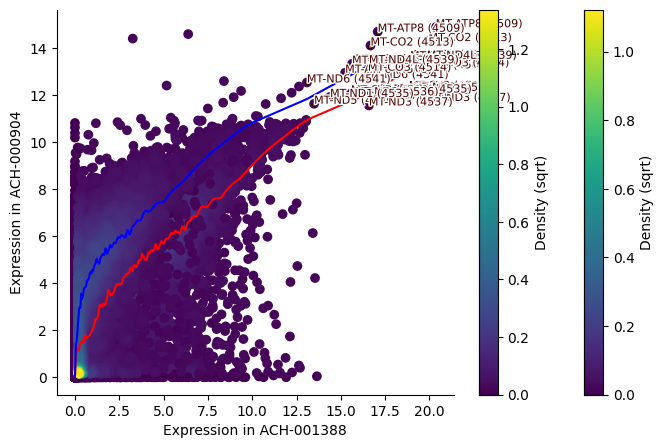

In [39]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)

highest_sample = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc['ACH-001388', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax,
                         label_specific=chrM_labels)
sns.despine()
                         
ax.set_xlabel("Expression in ACH-001388")
ax.set_ylabel("Expression in ACH-000904")
#ax[0].set_xlim(0, 18)
#ax[0].set_ylim(0, 18)

# fig, ax = plt.subplots()
# fig.set_size_inches(8, 5)
highest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-001388', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax,
                         trend_line_args={'color': 'b'},
                         label_specific=chrM_labels)
sns.despine()
                       
ax.set_xlabel("Expression in ACH-001388")
ax.set_ylabel("Expression in ACH-000904")
#ax[1].set_xlim(0, 18)
#ax[1].set_ylim(0, 18)

Text(0, 0.5, 'Expression in ACH-000904')

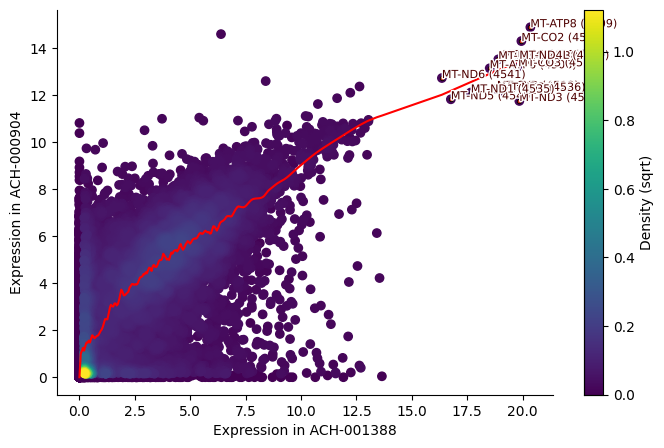

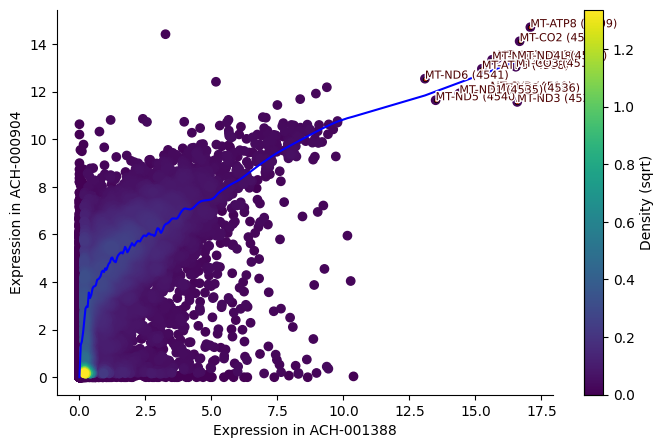

In [40]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)

highest_sample = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc['ACH-001388', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax,
                         label_specific=chrM_labels)
sns.despine()
                         
ax.set_xlabel("Expression in ACH-001388")
ax.set_ylabel("Expression in ACH-000904")
#ax[0].set_xlim(0, 18)
#ax[0].set_ylim(0, 18)

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
highest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-001388', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax,
                         trend_line_args={'color': 'b'},
                         label_specific=chrM_labels)
sns.despine()
                       
ax.set_xlabel("Expression in ACH-001388")
ax.set_ylabel("Expression in ACH-000904")
#ax[1].set_xlim(0, 18)
#ax[1].set_ylim(0, 18)

Text(0, 0.5, 'Expression in ACH-003106')

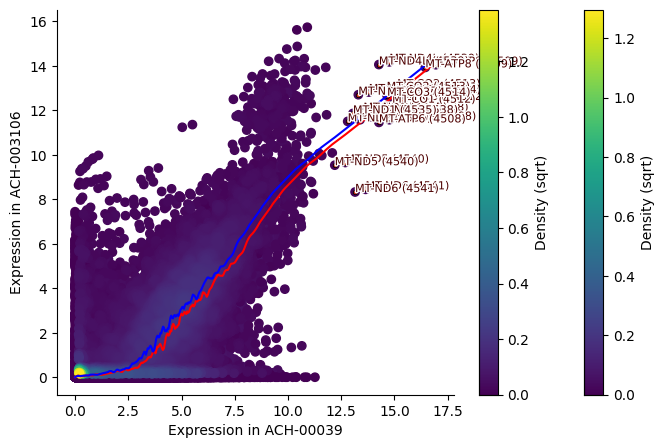

In [41]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)

highest_sample = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc['ACH-000399', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc['ACH-003106', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax,
                         label_specific=chrM_labels)
sns.despine()
                         
ax.set_xlabel("Expression in ACH-00039")
ax.set_ylabel("Expression in ACH-003106")
#ax[0].set_xlim(0, 18)
#ax[0].set_ylim(0, 18)

# fig, ax = plt.subplots()
# fig.set_size_inches(8, 5)
highest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-000399', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-003106', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax,
                         trend_line_args={'color': 'b'},
                         label_specific=chrM_labels)
sns.despine()
                       
ax.set_xlabel("Expression in ACH-00039")
ax.set_ylabel("Expression in ACH-003106")
#ax[1].set_xlim(0, 18)
#ax[1].set_ylim(0, 18)

## Upload this new version of datasets

In [42]:
OmicsExpressionGenesExpectedCountModel_tpm_chrM.to_csv("OmicsExpressionGenesExpectedCountModel_tpm_chrM.csv")

In [43]:
update = True
if update:
   new_dataset_id = tc.update_dataset(
        dataset_id="post-23q4-gene-expression-renormalization-chrm-8a6b",
        changes_description="post 23Q4 adjust gene expression normalization 2",
        upload_files=[
            {
                "path": "OmicsExpressionGenesExpectedCountModel_tpm_chrM.csv",
                "name": "OmicsExpressionGenesExpectedCountModel_tpm_chrM", # optional, will use file name if not provided
                "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
                "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
            }
        ],
        upload_async=False,
        dataset_description="post 23Q4 adjust gene expression normalization",
   )
else:
   new_dataset_id = tc.create_dataset(
       "post-23q4-gene-expression-renormalization-chrM",
       dataset_description="post 23Q4 adjust gene expression normalization",
       upload_files=[
           {
               "path": "OmicsExpressionGenesExpectedCountModel_tpm_chrM.csv",
               "name": "OmicsExpressionGenesExpectedCountModel_tpm_chrM", # optional, will use file name if not provided
               "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
               "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
           }
       ],
       folder_id="a9eedc220a6a4e70b8f1e64d2e57ed87", # optional, will default to your home folder if not provided
   )

new_dataset_id

No dataset version provided. Using version 3.
Linking virtual file OmicsExpressionGenesExpectedCountModel_tpm_chrM
Dataset version created. Access it directly with this url: https://cds.team/taiga/dataset_version/cc3e017b99e2400a86479d2d2828ddc3


'cc3e017b99e2400a86479d2d2828ddc3'

# Square root normalization

In [54]:
def calculate_tpm_correct_chrM(counts_df, transcripts_length_df, chrM=True):
    """https://github.com/deweylab/RSEM/blob/8bc1e2115493c0cdf3c6bee80ef7a21a91b2acce/WriteResults.h#L77"""
    assert counts_df.shape == transcripts_length_df.shape
    EPSILON = 1e-300

    chrM_labels = counts_df.columns.str.contains("^MT-")
    print(chrM_labels.sum())

    if chrM:
        denom = counts_df.loc[:, ~chrM_labels].sum(axis=1)
    else:
        denom = counts_df.sum(axis=1)

    denom = denom.where(denom > EPSILON, 1)
    print(denom.isnull().sum().sum())
    frac = counts_df.div(denom, axis=0)
    print(frac.isnull().sum().sum())

    transcripts_length_df = transcripts_length_df.where(transcripts_length_df > EPSILON, 1)
    fpkm = frac * 1e9 / transcripts_length_df
    print(fpkm.isnull().sum().sum())

    if chrM:
        fpkm_sum = fpkm.loc[:, ~chrM_labels].sum(axis=1)
    else:
        fpkm_sum = fpkm.sum(axis=1)

    fpkm_denom = fpkm_sum.where(fpkm_sum > EPSILON, 1)
    print(fpkm_denom.isnull().sum().sum())

    tpm_df = (fpkm.div(fpkm_denom, axis=0)) * 1e6
    print(tpm_df.isnull().sum().sum())
    return np.sqrt(tpm_df+1)

In [55]:
OmicsExpressionGenesExpectedCountProfile_tpm_sqrt = calculate_tpm_correct_chrM(OmicsExpressionGenesExpectedCountProfile, 
                                                                               OmicsExpressionAllGenesEffectiveLengthProfile_matched_genes, chrM=False)
OmicsExpressionGenesExpectedCountProfile_tpm_sqrt.columns = OmicsExpressionGenesExpectedCountProfile_tpm_sqrt.columns.map(protcod_rename)
OmicsExpressionGenesExpectedCountProfile_tpm_sqrt = OmicsExpressionGenesExpectedCountProfile_tpm_sqrt.loc[:, ~OmicsExpressionGenesExpectedCountProfile_tpm_sqrt.columns.isnull()]

OmicsExpressionGenesExpectedCountProfile_tpm_sqrt.loc[:, "Model"] = OmicsExpressionGenesExpectedCountProfile_tpm_sqrt.index.map(profile_to_model_dict)
OmicsExpressionGenesExpectedCountModel_tpm_sqrt = OmicsExpressionGenesExpectedCountProfile_tpm_sqrt.set_index("Model")
OmicsExpressionGenesExpectedCountModel_tpm_sqrt = OmicsExpressionGenesExpectedCountModel_tpm_sqrt.loc[OmicsExpressionProteinCodingGenesTPMLogp1.index, :]

15
0
0
0
0
0


In [56]:
OmicsExpressionGenesExpectedCountProfile_tpm_chrM = calculate_tpm_correct_chrM(OmicsExpressionGenesExpectedCountProfile, 
                                                                               OmicsExpressionAllGenesEffectiveLengthProfile_matched_genes)
OmicsExpressionGenesExpectedCountProfile_tpm_chrM.columns = OmicsExpressionGenesExpectedCountProfile_tpm_chrM.columns.map(protcod_rename)
OmicsExpressionGenesExpectedCountProfile_tpm_chrM = OmicsExpressionGenesExpectedCountProfile_tpm_chrM.loc[:, ~OmicsExpressionGenesExpectedCountProfile_tpm_chrM.columns.isnull()]

OmicsExpressionGenesExpectedCountProfile_tpm_chrM.loc[:, "Model"] = OmicsExpressionGenesExpectedCountProfile_tpm_chrM.index.map(profile_to_model_dict)
OmicsExpressionGenesExpectedCountModel_tpm_chrM = OmicsExpressionGenesExpectedCountProfile_tpm_chrM.set_index("Model")
OmicsExpressionGenesExpectedCountModel_tpm_chrM = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc[OmicsExpressionProteinCodingGenesTPMLogp1.index, :]

15
0
0
0
0
0


Text(0.5, 0, 'All gene median expression')

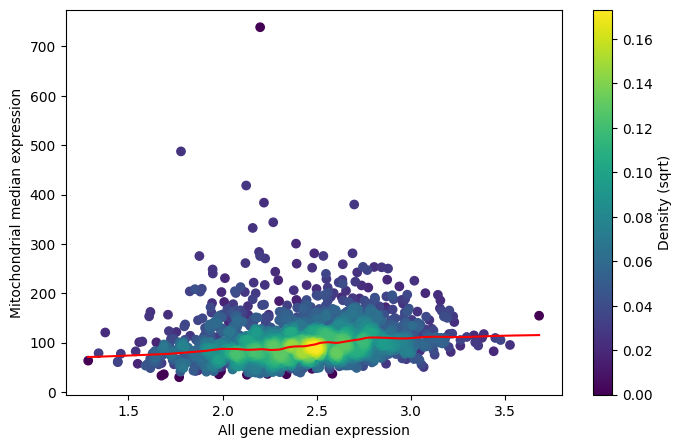

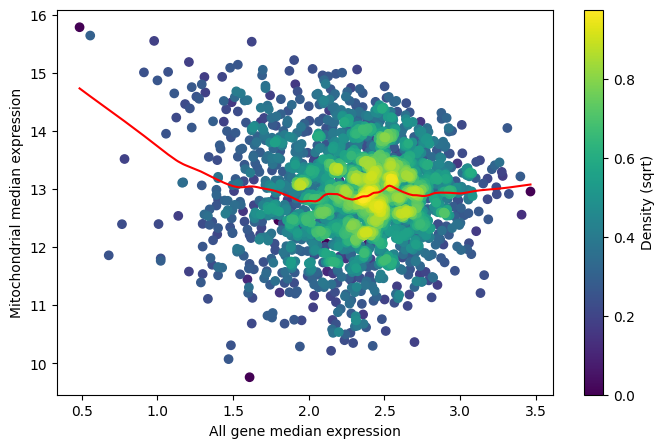

In [57]:
chrM_labels = OmicsExpressionGenesExpectedCountModel_tpm_chrM.columns[OmicsExpressionGenesExpectedCountModel_tpm_chrM.columns.str.contains("^MT-")]

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
plotting.density_scatter(OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc[:, :].median(axis=1),
                         OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc[:, chrM_labels].median(axis=1),
                         ax=ax)
ax.set_ylabel("Mitochondrial median expression")
ax.set_xlabel("All gene median expression")
#ax.set_ylim(0, 200)

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
plotting.density_scatter(OmicsExpressionAllGenesTPMLogp1Profile.loc[:, :].median(axis=1),
                         OmicsExpressionAllGenesTPMLogp1Profile.loc[:, chrM_labels].median(axis=1),
                         ax=ax)
ax.set_ylabel("Mitochondrial median expression")
ax.set_xlabel("All gene median expression")

Text(0.5, 0, 'All gene median expression')

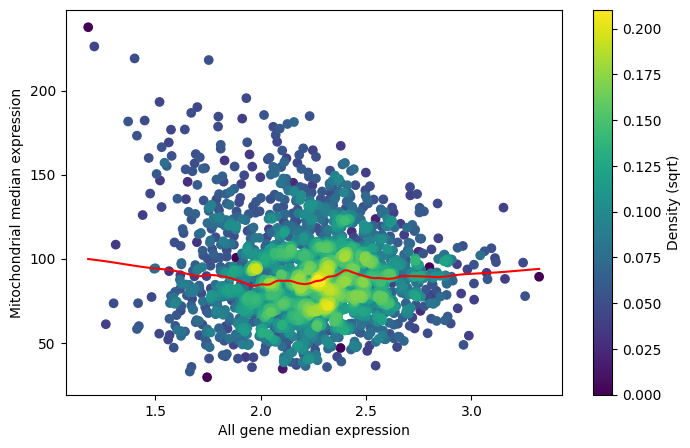

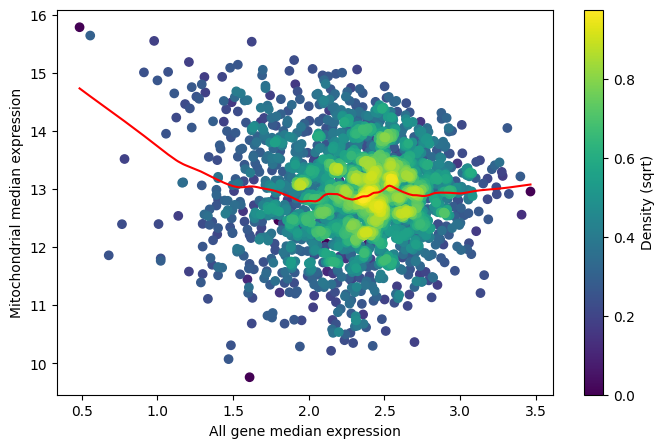

In [62]:
chrM_labels = OmicsExpressionGenesExpectedCountModel_tpm_sqrt.columns[OmicsExpressionGenesExpectedCountModel_tpm_sqrt.columns.str.contains("^MT-")]

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
plotting.density_scatter(OmicsExpressionGenesExpectedCountModel_tpm_sqrt.loc[:, :].median(axis=1),
                         OmicsExpressionGenesExpectedCountModel_tpm_sqrt.loc[:, chrM_labels].median(axis=1),
                         ax=ax)
ax.set_ylabel("Mitochondrial median expression")
ax.set_xlabel("All gene median expression")
#ax.set_ylim(0, 200)

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
plotting.density_scatter(OmicsExpressionAllGenesTPMLogp1Profile.loc[:, :].median(axis=1),
                         OmicsExpressionAllGenesTPMLogp1Profile.loc[:, chrM_labels].median(axis=1),
                         ax=ax)
ax.set_ylabel("Mitochondrial median expression")
ax.set_xlabel("All gene median expression")

/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/cds/plotting/__init__.py:537: UserWarning: adjustText not found. Install to have labels moved off points.
  warn("adjustText not found. Install to have labels moved off points.")


Text(0, 0.5, 'Expression in ACH-000904')

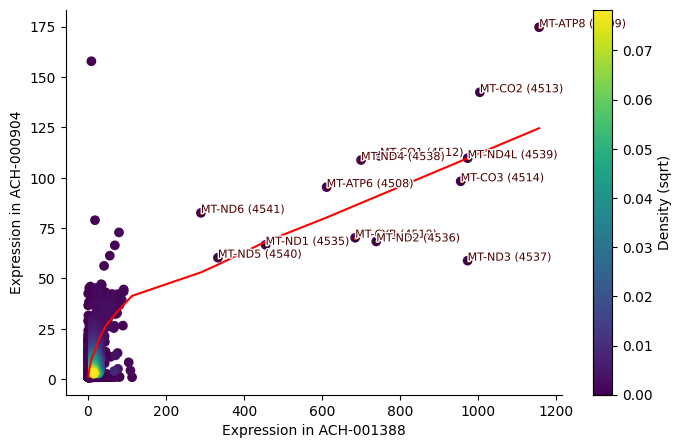

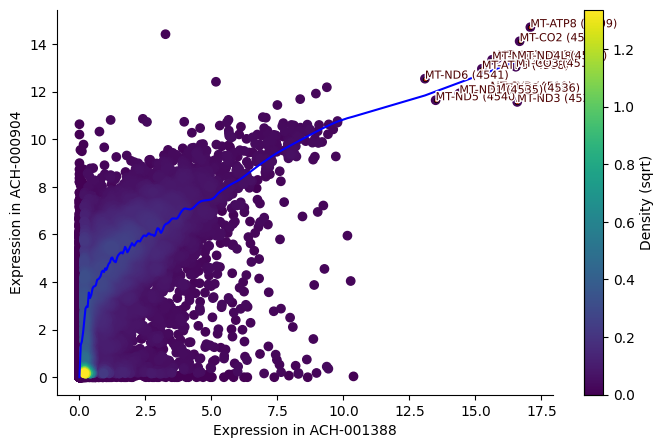

In [59]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)

highest_sample = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc['ACH-001388', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax,
                         label_specific=chrM_labels)
sns.despine()
                         
ax.set_xlabel("Expression in ACH-001388")
ax.set_ylabel("Expression in ACH-000904")
#ax[0].set_xlim(0, 18)
#ax[0].set_ylim(0, 18)

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
highest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-001388', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax,
                         trend_line_args={'color': 'b'},
                         label_specific=chrM_labels)
sns.despine()
                       
ax.set_xlabel("Expression in ACH-001388")
ax.set_ylabel("Expression in ACH-000904")
#ax[1].set_xlim(0, 18)
#ax[1].set_ylim(0, 18)

Text(0, 0.5, 'Expression in ACH-000904')

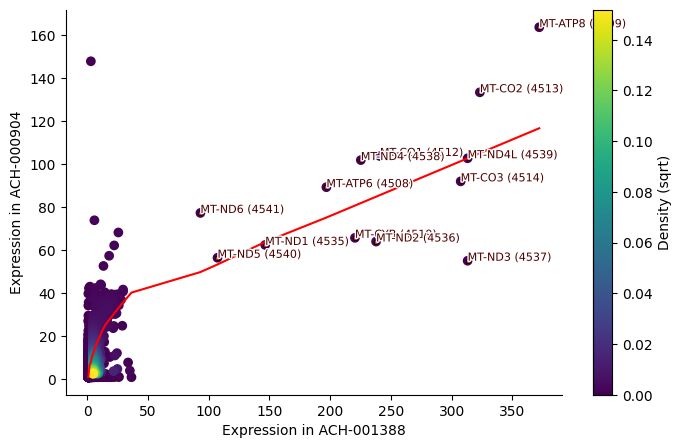

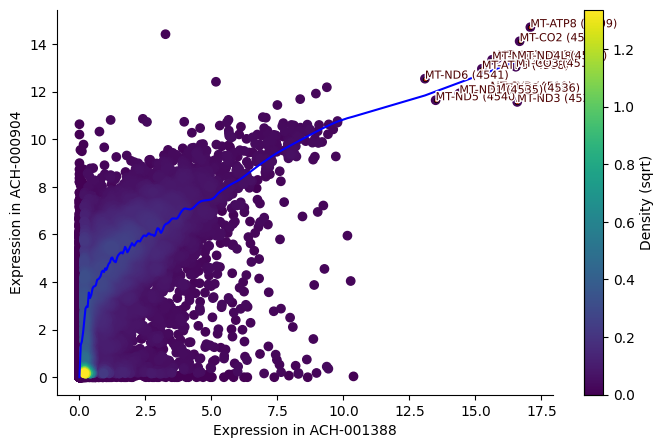

In [61]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)

highest_sample = OmicsExpressionGenesExpectedCountModel_tpm_sqrt.loc['ACH-001388', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm_sqrt.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax,
                         label_specific=chrM_labels)
sns.despine()
                         
ax.set_xlabel("Expression in ACH-001388")
ax.set_ylabel("Expression in ACH-000904")
#ax[0].set_xlim(0, 18)
#ax[0].set_ylim(0, 18)

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
highest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-001388', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax,
                         trend_line_args={'color': 'b'},
                         label_specific=chrM_labels)
sns.despine()
                       
ax.set_xlabel("Expression in ACH-001388")
ax.set_ylabel("Expression in ACH-000904")
#ax[1].set_xlim(0, 18)
#ax[1].set_ylim(0, 18)

In [63]:
OmicsExpressionGenesExpectedCountModel_tpm_chrM.to_csv("OmicsExpressionGenesExpectedCountModel_tpm_chrM_sqrt.csv")

In [68]:
update = True
if update:
   new_dataset_id = tc.update_dataset(
        dataset_id="post-23q4-gene-expression-renormalization-chrm-sqrt-e82f",
        changes_description="post 23Q4 adjust gene expression normalization square root normalization after removing chrM from denomitor",
        upload_files=[
            {
                "path": "OmicsExpressionGenesExpectedCountModel_tpm_chrM_sqrt.csv",
                "name": "OmicsExpressionGenesExpectedCountModel_tpm_chrM_sqrt", # optional, will use file name if not provided
                "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
                "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
            }
        ],
        upload_async=False,
        dataset_description="post 23Q4 adjust gene expression normalization after removing chrM",
   )
else:
   new_dataset_id = tc.create_dataset(
       "post-23q4-gene-expression-renormalization-chrM-sqrt",
       dataset_description="post 23Q4 adjust gene expression normalization",
       upload_files=[
           {
               "path": "OmicsExpressionGenesExpectedCountModel_tpm_chrM_sqrt.csv",
               "name": "OmicsExpressionGenesExpectedCountModel_tpm_chrM_sqrt", # optional, will use file name if not provided
               "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
               "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
           }
       ],
       folder_id="a9eedc220a6a4e70b8f1e64d2e57ed87", # optional, will default to your home folder if not provided
   )

new_dataset_id

No dataset version provided. Using version 3.
Linking virtual file OmicsExpressionGenesExpectedCountModel_tpm_chrM_sqrt
Dataset version created. Access it directly with this url: https://cds.team/taiga/dataset_version/57cac9b7bfc846f49d8684ff3c4fa7ba


'57cac9b7bfc846f49d8684ff3c4fa7ba'

In [65]:
OmicsExpressionGenesExpectedCountModel_tpm_sqrt.to_csv("OmicsExpressionGenesExpectedCountModel_tpm_sqrt.csv")

In [67]:
update = False
if update:
   new_dataset_id = tc.update_dataset(
        dataset_id="post-23q4-gene-expression-renormalization-chrm-sqrt-e82f",
        changes_description="post 23Q4 adjust gene expression normalization square root normalization after removing chrM from denomitor",
        upload_files=[
            {
                "path": "OmicsExpressionGenesExpectedCountModel_tpm_chrM_sqrt.csv",
                "name": "OmicsExpressionGenesExpectedCountModel_tpm_chrM_sqrt", # optional, will use file name if not provided
                "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
                "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
            }
        ],
        upload_async=False,
        dataset_description="post 23Q4 adjust gene expression normalization after removing chrM",
   )
else:
   new_dataset_id = tc.create_dataset(
       "post-23q4-gene-expression-renormalization-sqrt",
       dataset_description="post 23Q4 adjust gene expression normalization",
       upload_files=[
           {
               "path": "OmicsExpressionGenesExpectedCountModel_tpm_sqrt.csv",
               "name": "OmicsExpressionGenesExpectedCountModel_tpm_sqrt", # optional, will use file name if not provided
               "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
               "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
           }
       ],
       folder_id="a9eedc220a6a4e70b8f1e64d2e57ed87", # optional, will default to your home folder if not provided
   )

new_dataset_id

Uploading OmicsExpressionGenesExpectedCountModel_tpm_sqrt to S3
Finished uploading OmicsExpressionGenesExpectedCountModel_tpm_sqrt to S3
Uploading OmicsExpressionGenesExpectedCountModel_tpm_sqrt to Taiga
Finished uploading OmicsExpressionGenesExpectedCountModel_tpm_sqrt to Taiga
Dataset created. Access it directly with this url: https://cds.team/taiga/dataset/7977896460ef4f829ee5da134160732c



'7977896460ef4f829ee5da134160732c'

# Aggregate read count table for testing

In [2]:
import pandas as pd
import dalmatian as dm

In [3]:
wm = dm.WorkspaceManager("broad-firecloud-ccle/DEV_DepMap_hg38_RNAseq")
terra_rnaseq_df = wm.get_samples()

In [95]:
def load_rnaseqc(terra_path):
    rnaseqc_count_df = pd.read_csv(terra_path, sep='\t', skiprows=2)
    rnaseqc_count_df = rnaseqc_count_df.set_index(rnaseqc_count_df.apply(lambda x: f"{x[1]} ({x[0].split('.')[0]})", axis=1))
    rnaseqc_count_df = rnaseqc_count_df.drop(["Name", "Description"], axis=1)
    return rnaseqc_count_df

In [5]:
from multiprocessing import Pool
pool = Pool(8)
rnaseqc_count_dfs = pool.map(load_rnaseqc, terra_rnaseq_df.rnaseqc2_gene_counts)

In [6]:
pool.close()

In [192]:
rnaseqc_count_mat = pd.concat(rnaseqc_count_dfs, axis=1)

In [193]:
rnaseqc_count_mat = rnaseqc_count_mat.T

In [194]:
rnaseqc_count_mat.shape

(1704, 57975)

In [195]:
import pickle
with open("/home/ubuntu/pr_table.pkl", "rb") as input_file:
    pr_dict = pickle.load(input_file)

In [196]:
rnaseqc_count_mat.index = rnaseqc_count_mat.index.map(pr_dict)

In [197]:
rnaseqc_count_mat.head()

,DDX11L1 (ENSG00000223972),WASH7P (ENSG00000227232),MIR6859-1 (ENSG00000278267),MIR1302-2HG (ENSG00000243485),MIR1302-2 (ENSG00000284332),FAM138A (ENSG00000237613),OR4G4P (ENSG00000268020),OR4G11P (ENSG00000240361),OR4F5 (ENSG00000186092),AL627309.1 (ENSG00000238009),...,ERCC-00157 (ERCC-00157),ERCC-00158 (ERCC-00158),ERCC-00160 (ERCC-00160),ERCC-00162 (ERCC-00162),ERCC-00163 (ERCC-00163),ERCC-00164 (ERCC-00164),ERCC-00165 (ERCC-00165),ERCC-00168 (ERCC-00168),ERCC-00170 (ERCC-00170),ERCC-00171 (ERCC-00171)
PR-AdBjpG,0,193,0,0,0,0,0,0,0,15,...,0,0,4,88,16,0,26,2,16,2177
PR-I2AzwG,0,108,0,4,1,0,0,1,2,7,...,0,0,0,0,0,0,0,0,0,0
PR-5ekAAC,0,179,0,1,0,1,2,3,3,8,...,20,2,24,357,67,0,127,4,65,11630
NaN,1,184,0,0,0,0,0,1,0,1,...,52,2,38,346,119,0,97,4,85,17204
PR-DuAy1L,0,49,0,0,0,0,0,1,4,1,...,34,8,63,303,90,0,193,0,46,11540


In [198]:
rnaseqc_count_mat = rnaseqc_count_mat.loc[~rnaseqc_count_mat.index.isnull(), :]

In [199]:
rnaseqc_count_mat.shape

(1649, 57975)

In [200]:
rnaseqc_count_lengths = OmicsExpressionAllGenesEffectiveLengthProfile.loc[:, np.intersect1d(rnaseqc_count_mat.columns, OmicsExpressionAllGenesEffectiveLengthProfile.columns)]

In [201]:
rnaseqc_count_mat.shape, rnaseqc_count_lengths.shape

((1649, 57975), (1904, 52101))

In [202]:
rnaseqc_count_lengths = rnaseqc_count_lengths.loc[np.intersect1d(rnaseqc_count_mat.index, rnaseqc_count_lengths.index), :]

In [203]:
rnaseqc_count_lengths.shape

(1585, 52101)

In [204]:
rnaseqc_count_mat = rnaseqc_count_mat.loc[rnaseqc_count_lengths.index, :]

In [205]:
rnaseqc_count_mat = rnaseqc_count_mat.loc[:, rnaseqc_count_lengths.columns]

In [206]:
rnaseqc_count_mat.shape

(1585, 52143)

In [207]:
rnaseqc_count_mat = rnaseqc_count_mat.loc[:, ~rnaseqc_count_mat.columns.duplicated()]

In [208]:
rnaseqc_count_mat.shape

(1585, 52101)

In [212]:
rnaseqc_count_mat.head()

,A1BG (ENSG00000121410),A1BG-AS1 (ENSG00000268895),A1CF (ENSG00000148584),A2M (ENSG00000175899),A2M-AS1 (ENSG00000245105),A2ML1 (ENSG00000166535),A2ML1-AS1 (ENSG00000256661),A2ML1-AS2 (ENSG00000256904),A2MP1 (ENSG00000256069),A3GALT2 (ENSG00000184389),...,ZWINT (ENSG00000122952),ZXDA (ENSG00000198205),ZXDB (ENSG00000198455),ZXDC (ENSG00000070476),ZYG11A (ENSG00000203995),ZYG11AP1 (ENSG00000232242),ZYG11B (ENSG00000162378),ZYX (ENSG00000159840),ZYXP1 (ENSG00000274572),ZZEF1 (ENSG00000074755)
PR-01r7OM,6,54,290,18,34,3,1,0,0,1,...,16360,356,1530,2467,7,0,3429,32635,0,7308
PR-02XmLG,110,649,0,927,76,0,0,0,0,0,...,14947,413,3384,1840,6,0,15337,17481,0,5581
PR-09gmEI,1089,483,11,128,21,6,19,0,5,4,...,10532,284,1628,2588,2138,0,7210,33776,0,5601
PR-0B6q0Z,11,35,7,9,52,3,16,0,0,6,...,30062,191,954,1470,1045,0,3704,23673,0,4703
PR-0CHfFI,8,97,0,10,69,107,8,0,4,0,...,11505,952,7561,1884,9,0,5503,38806,0,7317


In [213]:
rnaseqc_count_mat.to_csv("rnaseqc_count_mat.csv")

In [214]:
update = False
if update:
   new_dataset_id = tc.update_dataset(
        dataset_id="post-23q4-gene-expression-renormalization-chrm-8a6b",
        changes_description="post 23Q4 adjust gene expression normalization 2",
        upload_files=[
            {
                "path": "OmicsExpressionGenesExpectedCountModel_tpm_chrM_sqrt.csv",
                "name": "OmicsExpressionGenesExpectedCountModel_tpm_chrM", # optional, will use file name if not provided
                "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
                "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
            }
        ],
        upload_async=False,
        dataset_description="post 23Q4 adjust gene expression normalization",
   )
else:
   new_dataset_id = tc.create_dataset(
       "rnqseqc2_gene_count_profile",
       dataset_description="rnqseqc2 count profile",
       upload_files=[
           {
               "path": "rnaseqc_count_mat.csv",
               "name": "rnqseqc2_gene_count_profile", # optional, will use file name if not provided
               "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
               "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
           }
       ],
       folder_id="a9eedc220a6a4e70b8f1e64d2e57ed87", # optional, will default to your home folder if not provided
   )

new_dataset_id

Uploading rnqseqc2_gene_count_profile to S3
Finished uploading rnqseqc2_gene_count_profile to S3
Uploading rnqseqc2_gene_count_profile to Taiga
Finished uploading rnqseqc2_gene_count_profile to Taiga
Dataset created. Access it directly with this url: https://cds.team/taiga/dataset/b5c4744eebab418a803c1987e90af25a



'b5c4744eebab418a803c1987e90af25a'

In [163]:
rnaseqc_count_mat_tpm = calculate_tpm_correct_chrM_log(rnaseqc_count_mat, rnaseqc_count_lengths)

37
0
0
0
0
0


In [165]:
rnaseqc_count_mat_tpm.head()

,A1BG (ENSG00000121410),A1BG-AS1 (ENSG00000268895),A1CF (ENSG00000148584),A2M (ENSG00000175899),A2M-AS1 (ENSG00000245105),A2ML1 (ENSG00000166535),A2ML1-AS1 (ENSG00000256661),A2ML1-AS2 (ENSG00000256904),A2MP1 (ENSG00000256069),A3GALT2 (ENSG00000184389),...,ZWINT (ENSG00000122952),ZXDA (ENSG00000198205),ZXDB (ENSG00000198455),ZXDC (ENSG00000070476),ZYG11A (ENSG00000203995),ZYG11AP1 (ENSG00000232242),ZYG11B (ENSG00000162378),ZYX (ENSG00000159840),ZYXP1 (ENSG00000274572),ZZEF1 (ENSG00000074755)
PR-01r7OM,0.059474,0.401435,0.705947,0.182850,0.212230,0.015394,0.076179,0.0,0.000000,0.020783,...,7.005487,0.872316,2.094132,3.260706,0.026600,0.0,2.555288,7.613109,0.0,3.563383
PR-02XmLG,2.254326,2.542253,0.000000,2.275013,0.419993,0.000000,0.000000,0.0,0.000000,0.000000,...,6.965200,0.855300,2.821624,2.976353,0.019210,0.0,4.258689,6.609216,0.0,3.028689
PR-09gmEI,5.185779,1.906509,0.016845,0.506588,0.167469,0.107591,0.823610,0.0,0.043514,0.067417,...,6.175759,0.648464,1.993348,3.284161,2.570536,0.0,3.284687,7.383111,0.0,3.055198
PR-0B6q0Z,0.087784,0.293352,0.108657,0.032893,0.359153,0.015455,0.966463,0.0,0.000000,0.123500,...,8.060430,0.532327,1.604463,2.697180,1.936875,0.0,2.638723,7.154111,0.0,2.907798
PR-0CHfFI,0.442657,0.584569,0.000000,0.469087,0.344766,0.268063,0.489141,0.0,0.032562,0.000000,...,6.150392,1.388757,3.673844,2.723901,0.028404,0.0,2.730214,7.396750,0.0,2.954178


In [169]:
rnaseqc_count_mat_tpm.columns = rnaseqc_count_mat_tpm.columns.map(protcod_rename)
rnaseqc_count_mat_tpm = rnaseqc_count_mat_tpm.loc[:, ~rnaseqc_count_mat_tpm.columns.isnull()]

In [177]:
rnaseqc_count_mat_tpm.shape

(1585, 18794)

In [178]:
rnaseqc_count_mat_tpm.index = rnaseqc_count_mat_tpm.index.map(profile_to_model_dict)

In [181]:
rnaseqc_count_mat_tpm.shape

(1585, 18794)

In [183]:
rnaseqc_count_mat_tpm = rnaseqc_count_mat_tpm.loc[~rnaseqc_count_mat_tpm.index.isnull(), :]

In [185]:
rnaseqc_count_mat_tpm.shape

(1569, 18794)

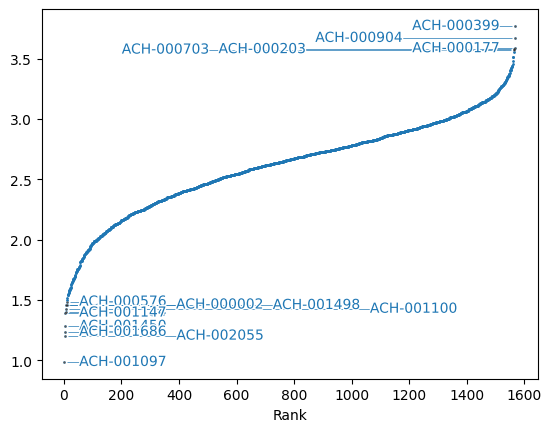

In [186]:
new_sample_median_expression = rnaseqc_count_mat_tpm.median(axis=1)
plotting.waterfall_plot(new_sample_median_expression, s=1)

Text(0.5, 0, 'All gene median expression')

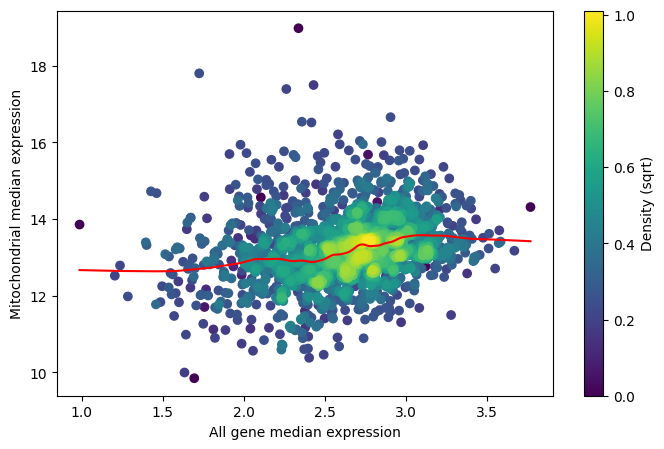

In [188]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
chrM_labels = rnaseqc_count_mat_tpm.columns[rnaseqc_count_mat_tpm.columns.str.contains("^MT-")]

plotting.density_scatter(rnaseqc_count_mat_tpm.loc[:, :].median(axis=1),
                         rnaseqc_count_mat_tpm.loc[:, chrM_labels].median(axis=1),
                         ax=ax)
ax.set_ylabel("Mitochondrial median expression")
ax.set_xlabel("All gene median expression")

(0.0, 18.0)

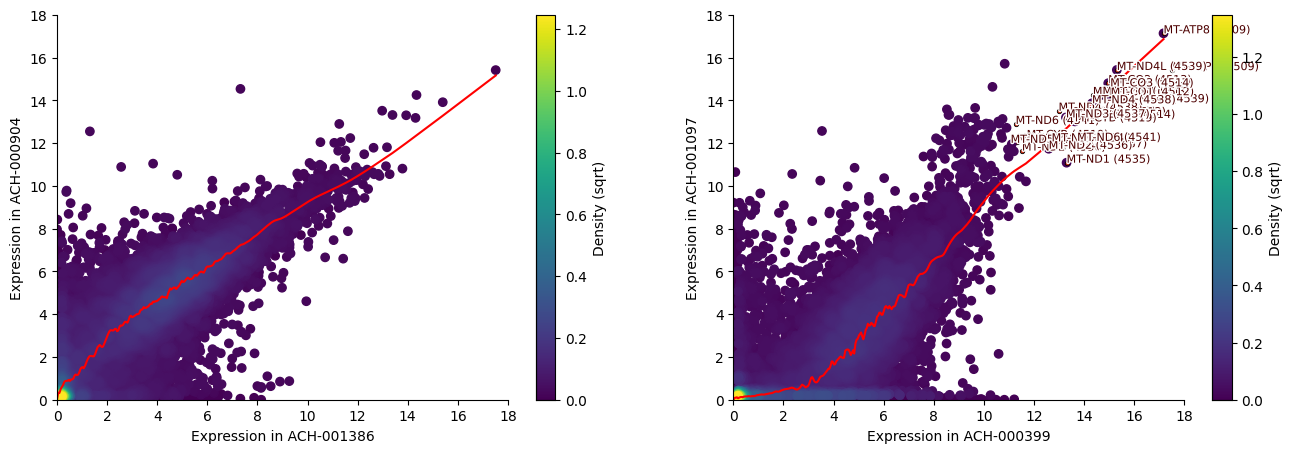

In [211]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(16, 5)
chrM_labels = rnaseqc_count_mat_tpm.columns[rnaseqc_count_mat_tpm.columns.str.contains("^MT-")]
highest_sample = rnaseqc_count_mat_tpm.loc['ACH-001386', :]
lowest_sample = rnaseqc_count_mat_tpm.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax[0],
                         label_specific=chrM_labels)
sns.despine()
                         
ax[0].set_xlabel("Expression in ACH-001386")
ax[0].set_ylabel("Expression in ACH-000904")
ax[0].set_xlim(0, 18)
ax[0].set_ylim(0, 18)


highest_sample = rnaseqc_count_mat_tpm.loc['ACH-000399', :]
lowest_sample = rnaseqc_count_mat_tpm.loc['ACH-001097', :]

plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax[1],
                         label_specific=chrM_labels)
sns.despine()
                         
ax[1].set_xlabel("Expression in ACH-000399")
ax[1].set_ylabel("Expression in ACH-001097")
ax[1].set_xlim(0, 18)
ax[1].set_ylim(0, 18)